# Imports and constants

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B, GradientDescent, ADAM
from qiskit_machine_learning.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit.circuit import Parameter
from qiskit.primitives import StatevectorEstimator as Estimator

algorithm_globals.random_seed = 42

from sklearn.datasets import fetch_openml

import torch

import torchvision.models as models
from qiskit_machine_learning.connectors import TorchConnector
from tqdm import tqdm

In [53]:
BACKEND = "qasm_simulator"
LR = 0.001
EPOCHS = 10
loss_func = torch.nn.NLLLoss()
BATCH_SIZE = 2

num_inputs = 2 # num of features (n)
num_samples = 64 # num of samples
num_params = 12 # num of parameters (m)
num_qubits = 2 # num of qubits

# Dataset

In [54]:
# Fetch the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# Extract data and target
X_mnist, y_mnist = mnist["data"], mnist["target"]

# Print statistics
print(f"Number of samples: {X_mnist.shape[0]}")
print(f"Number of features: {X_mnist.shape[1]}")
print(f"Number of classes: {len(set(y_mnist))}")
print(f"Classes: {set(y_mnist)}")

Number of samples: 70000
Number of features: 784
Number of classes: 10
Classes: {'8', '9', '3', '5', '1', '6', '7', '2', '4', '0'}


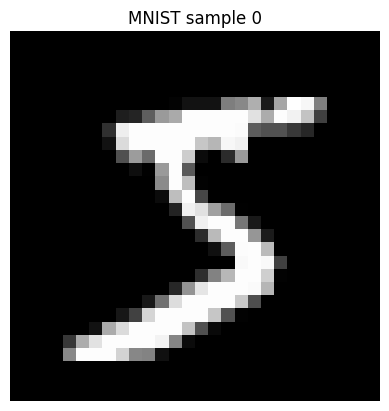

Label: 5


In [55]:
def plot_sample(i):
    # Reshape the i-th sample to a 28x28 image
    image = X_mnist.iloc[i].values.reshape(28, 28)

    # Plot the image
    plt.imshow(image, cmap='gray')
    plt.title(f"MNIST sample {i}")
    plt.axis('off')
    plt.show()

plot_sample(0)

print(f"Label: {y_mnist[0]}")

# Preprocess

In [56]:
# Load a pretrained ResNet model, trained on ImageNet so not MNIST
resnetBackbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

# Remove the last layer (fully connected layer)
resnetBackbone = torch.nn.Sequential(*(list(resnetBackbone.children())[:-1])) 

input = torch.randn(1, 3, 224, 224)
output = resnetBackbone(input)
print(output.shape)

# resnetbackbone :
#input shape : 1, 3, 224, 224
#output shape : 1, 512, 1, 1

torch.Size([1, 512, 1, 1])


In [57]:
print(type(X_mnist.values))
print(X_mnist.values[:5].shape)

for fqsdv in X_mnist.values[:5]:
    print(fqsdv.shape)

<class 'numpy.ndarray'>
(5, 784)
(784,)
(784,)
(784,)
(784,)
(784,)


In [58]:

img0 = X_mnist.values[0]

print(img0.shape)
img0_tensor = torch.tensor(img0 / 255)
print(type(img0_tensor.detach().numpy()))
print(img0_tensor.detach().numpy().max())

(784,)
<class 'numpy.ndarray'>
1.0


In [59]:
# now we create the input we will use : one image = (512, 1, 1)

def processImage(image):
    """
    input shape : 784
    output shape : 1, 3, 224, 224
    """
    normalized_tensor = torch.tensor(image / 255.0, dtype=torch.float32)
    square_normalized_tensor = normalized_tensor.reshape(1, 1, 28, 28)
    reshaped_normalized_tensor = torch.nn.functional.interpolate(square_normalized_tensor, size=(224, 224), mode="bilinear")
    reshaped_normalized_tensor = reshaped_normalized_tensor.repeat(1, 3, 1, 1)

    return reshaped_normalized_tensor

#a = processImage(X_mnist.values[0])
#plt.imshow(a[0].permute(1, 2, 0).detach().numpy())

In [60]:
X = torch.stack([resnetBackbone(processImage(image)) for image in X_mnist.values[:num_samples]])
Y = torch.tensor([int(label) for label in y_mnist[:num_samples]])
# X.shape = (64, 1, 512, 1, 1)
# Y.shape = (64)

X = X.view(-1, BATCH_SIZE, 512, 1, 1)
Y = Y.view(-1, BATCH_SIZE)
# X.shape = (32, 2, 512, 1, 1)
# Y.shape = (32, 2)



# Circuit

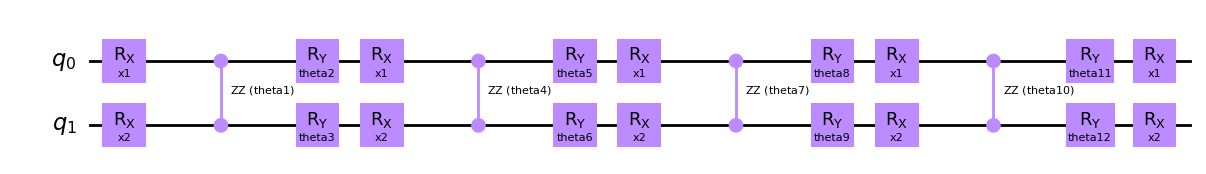

In [61]:
# 14 parameters : x1, x2, theta1, ...theta12
params = [Parameter(f"x{i}") for i in range(1, num_inputs+1)] + [Parameter(f"theta{i}") for i in range(1, num_params+1)]

qcc = QuantumCircuit(num_qubits) 

x1 = params[0]
x2 = params[1]
theta1 = params[2]
theta2 = params[3]
theta3 = params[4]
theta4 = params[5]
theta5 = params[6]
theta6 = params[7]
theta7 = params[8]
theta8 = params[9]
theta9 = params[10]
theta10 = params[11]
theta11 = params[12]
theta12 = params[13]

qcc.rx(x1, 0)
qcc.rx(x2, 1)
qcc.rzz(theta1, 0, 1)
qcc.ry(theta2, 0)
qcc.ry(theta3, 1)
qcc.rx(x1, 0)
qcc.rx(x2, 1)
qcc.rzz(theta4, 0, 1)
qcc.ry(theta5, 0)
qcc.ry(theta6, 1)
qcc.rx(x1, 0)
qcc.rx(x2, 1)
qcc.rzz(theta7, 0, 1)
qcc.ry(theta8, 0)
qcc.ry(theta9, 1)
qcc.rx(x1, 0)
qcc.rx(x2, 1)
qcc.rzz(theta10, 0, 1)
qcc.ry(theta11, 0)
qcc.ry(theta12, 1)
qcc.rx(x1, 0)
qcc.rx(x2, 1)


qcc.draw("mpl", style="clifford")

In [62]:
estimator = Estimator()

qnn = EstimatorQNN(
    circuit=qcc,
    input_params=[x1, x2],
    weight_params=params[2:],
    input_gradients=True,
    estimator=estimator,
)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [63]:
# The classical part : 
# input shape = [batchSize, 512, 1, 1] (output of resnetBackbone)
# output shape = [batchSize, 2] (which will be given to qcc as x1 and x2)

class hybridModel(torch.nn.Module):
    def __init__(self, qnn):
        super().__init__()
        self.flatten = torch.nn.Flatten()
        self.fc1 = torch.nn.Linear(512, 2)
        self.qnn = TorchConnector(qnn)
    
    def forward(self, x):
        #print('a', x.shape)
        x = self.flatten(x) # [batchSize, 512, 1, 1] -> [batchSize, 512]
        #print('b', x.shape)
        x = self.fc1(x) # [batchSize, 512] -> [batchSize, 2]
        #print('c', x.shape)
        x = self.qnn(x)
        #print('d', x.shape)
        return x

In [64]:
hybridmodel = hybridModel(qnn)

In [65]:
res = hybridmodel(X[0])

print(res.shape)

torch.Size([2, 1])


In [76]:
print(res[1])


tensor([0.1281], grad_fn=<SelectBackward0>)


In [66]:
optimizer = torch.optim.Adagrad(hybridmodel.parameters(), lr=LR)

# TODO : test adagrad, cobyla

In [72]:
def train(model, X, Y, optimizer, loss_func, epochs):
    print("X.shape", X.shape)
    print("Y.shape", Y.shape)
    for epoch in tqdm(range(epochs)):
        epoch_loss = 0
        for i in range(len(X)):
            optimizer.zero_grad()
            output = model(X[i])
            loss = loss_func(output, Y[i])
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch+1} - Loss : {epoch_loss}")

In [73]:
train(hybridmodel, X, Y, optimizer, loss_func, EPOCHS)

X.shape torch.Size([32, 2, 512, 1, 1])
Y.shape torch.Size([32, 2])


  0%|          | 0/10 [00:00<?, ?it/s]


IndexError: Target 5 is out of bounds.